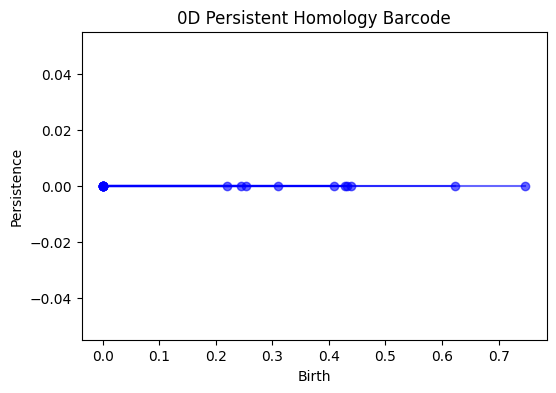

In [13]:
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt

# 生成随机 n 维点云数据
N, n = 10, 3  # 10个3维点
X = np.random.rand(N, n)

# 计算0维持续同调
diagrams = ripser(X)['dgms']

# 绘制持续条形码
plt.figure(figsize=(6,4))
for birth, death in diagrams[0]:
    if death == np.inf:  # 仅画出有限死亡的分量
        death = max(diagrams[0][:,1][diagrams[0][:,1] < np.inf]) * 1.2
    plt.plot([birth, death], [birth]*2, 'bo-', alpha=0.6)

plt.xlabel("Birth")
plt.ylabel("Persistence")
plt.title("0D Persistent Homology Barcode")
plt.show()


[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]
 [0.18182497 0.18340451]
 [0.30424224 0.52475643]
 [0.43194502 0.29122914]]
diagrams[0] is ... [[0.         0.0376467 ]
 [0.         0.11030351]
 [0.         0.17058939]
 [0.         0.26616347]
 [0.         0.27237141]
 [0.         0.32755369]
 [0.         0.33198071]
 [0.         0.34891009]
 [0.         0.39916489]
 [0.                inf]]


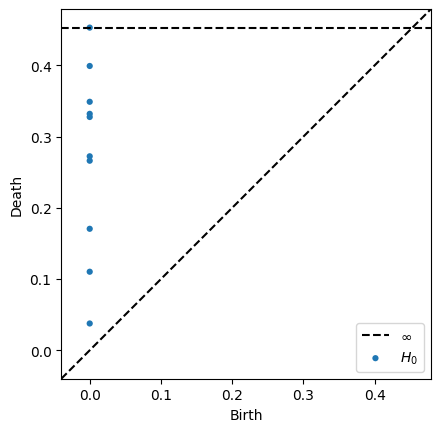

最小连通分量合并的圆半径: inf


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
from persim import plot_diagrams

def compute_minimum_connection_radius(points):
    # 计算欧几里得距离矩阵
    distance_matrix = squareform(pdist(points))
    
    # 计算 0 维持续同调
    result = ripser(distance_matrix, maxdim=0, distance_matrix=True)
    diagrams = result['dgms']  # 获取生死图数据
    print(f"diagrams[0] is ... {diagrams[0]}")
    
    # 提取 0 维度的生死时间
    H0 = diagrams[0]
    
    # 计算最后两个连通分量合并时的半径
    if len(H0) > 1:
        min_connect_radius = np.max(H0[:, 1])  # 取最大的死亡时间（即最小连通分量合并半径）
    else:
        min_connect_radius = 0  # 如果只有一个分量，说明已经连通
    
    return min_connect_radius, diagrams

# 生成 m 个 n 维点
m, n = 10, 2  # 10个2D点
np.random.seed(42)
points = np.random.rand(m, n)  # 在 (0,10) 范围内随机生成点
print(points)
# 计算最小连通半径 & 画生死图
min_radius, diagrams = compute_minimum_connection_radius(points)

# 绘制生死图
plot_diagrams(diagrams, show=True)
print(f"最小连通分量合并的圆半径: {min_radius}")


## 计算基于 Vietoris-Rips 复形，使所有向量最终合并为一个连通分量的最小半径

In [4]:
import numpy as np
import scipy.spatial.distance as dist
import gudhi as gd

def compute_min_radius_vr(vectors):
    """
    计算基于 Vietoris-Rips 复形，使所有向量最终合并为一个连通分量的最小半径 r_f。
    """
    # 计算欧几里得距离矩阵
    distance_matrix = dist.pdist(vectors, metric='euclidean')
    
    # 转换为方阵形式
    distance_matrix = dist.squareform(distance_matrix)
    
    # 构造 VR 复形
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    
    # 获取所有 1-维单纯形（边）的死亡时间，即当它们形成连通分量时的最大半径
    edges = [simplex for simplex in simplex_tree.get_filtration() if len(simplex[0]) == 2]
    
    # 找到形成单一连通分量的最小半径 r_f
    r_f = max(edge[1] for edge in edges)
    
    return r_f

# 生成 12 个 (1, 13, 768) 形状的随机向量
vectors = np.random.rand(12, 768)  # 这里去掉 batch 维度，使用 (12, 768)

# 计算最小半径
r_f = compute_min_radius_vr(vectors)
print(f"最小半径 r_f: {r_f}")


最小半径 r_f: 11.952418502241361


## 基于单链聚类实现

最小半径 r_f 使得所有点收敛到同一连通分量: 11.0793


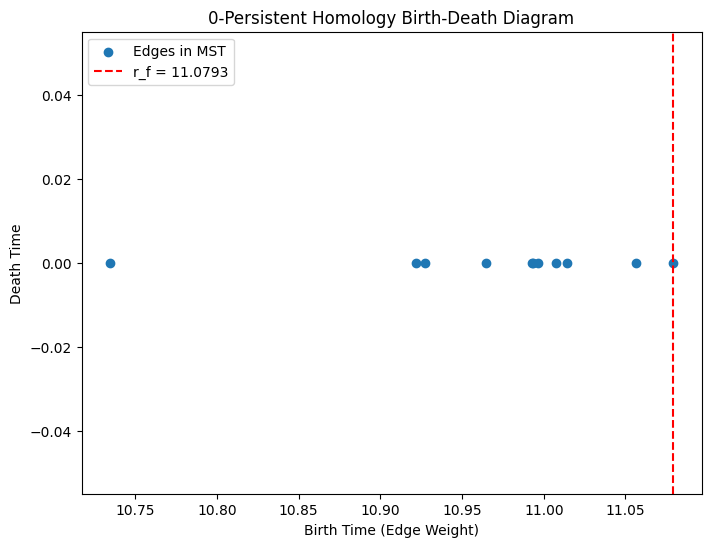

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import scipy.sparse.csgraph as graph
import networkx as nx

# 生成随机 12 组高维向量 (1,13,768) -> 变成 (12, 768)
np.random.seed(42)
points = np.random.rand(12, 768)  # 12 个 768 维向量

# 计算欧几里得距离矩阵
distance_matrix = dist.squareform(dist.pdist(points, metric="euclidean"))

# 计算最小生成树（MST）
mst = graph.minimum_spanning_tree(distance_matrix)
mst = mst.toarray()

# 找到 MST 中最长的边
r_f = np.max(mst[mst > 0])
print(f"最小半径 r_f 使得所有点收敛到同一连通分量: {r_f:.4f}")

# 获取 MST 边
edges = np.argwhere(mst > 0)
edge_weights = mst[mst > 0]

# 画 Birth-Death 持续同调图
plt.figure(figsize=(8, 6))
plt.scatter(edge_weights, np.zeros_like(edge_weights), marker="o", label="Edges in MST")
plt.axvline(x=r_f, color='r', linestyle='--', label=f"r_f = {r_f:.4f}")
plt.xlabel("Birth Time (Edge Weight)")
plt.ylabel("Death Time")
plt.title("0-Persistent Homology Birth-Death Diagram")
plt.legend()
plt.show()


<class 'numpy.ndarray'>
Vietoris-Rips 复形计算的最小连通半径 r_f: inf


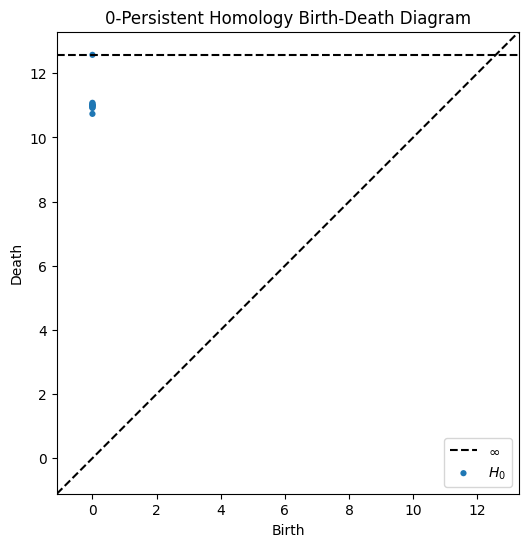

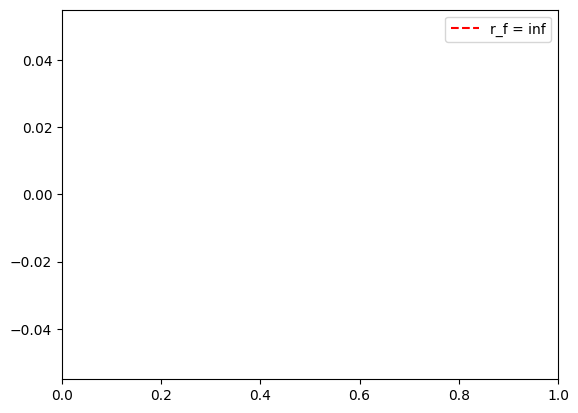

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
from persim import plot_diagrams
from ripser import ripser

# 生成 12 组高维向量 (1,13,768) -> 变成 (12, 768)
np.random.seed(42)
points = np.random.rand(12, 768)  # 12 个 768 维向量

# 计算欧几里得距离矩阵
distance_matrix = dist.squareform(dist.pdist(points, metric="euclidean"))

# 计算 Vietoris-Rips 复形的 0 维持续同调
homology = ripser(distance_matrix, maxdim=0, distance_matrix=True)['dgms'][0]
print(type(homology))
# 获取 0 维的最长持久性 (所有点最终连接的半径 r_f)
r_f = np.max(homology[:, 1])  # death time 最大值

print(f"Vietoris-Rips 复形计算的最小连通半径 r_f: {r_f:.4f}")

# 绘制 Birth-Death 持续同调图
plt.figure(figsize=(8, 6))
plot_diagrams([homology], show=True, title="0-Persistent Homology Birth-Death Diagram")
plt.axhline(y=r_f, color='r', linestyle='--', label=f"r_f = {r_f:.4f}")
plt.legend()
plt.show()
